In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import numpy as np 
import helper
from datetime import datetime
from matplotlib import pyplot as plt


# Datos


Los datos serán almacenados en memoria en 5 Data Frames distintos, los cuales contendrán la información vinculada a:

- Personas: Id, Fecha de Nacimiento, Género, Código Postal.
- Usuarios (Personas): Id(Personas), Ocupación, Fecha de Alta.
- Trabajadores (Personas): Id(Personas), Fecha de Alta, Puesto, Categoría, Horario de Trabajo.  
- Películas: Nombre, Año, Género(s), id.  
- Scores: Usuario (Id), Película (Id), Puntuación, Timestamp

In [2]:
personas_db = pd.read_csv("../Data/personas.csv")
personas_db.head()

,id,Full Name,year of birth,Gender,Zip Code
0,1,Robert Stanley,1974,M,85711
1,2,Heather Bossey,1945,F,94043
2,3,Don Davis,1975,M,32067
3,4,Daniel Mccauley,1974,M,43537
4,5,Janice Mccullough,1965,F,15213


In [3]:
usuarios_db = pd.read_csv("../Data/usuarios.csv")
usuarios_db.head()

,id,Occupation,Active Since
0,1,technician,1997-09-22 21:57:58
1,2,other,1998-02-27 03:26:00
2,3,writer,1998-03-07 02:15:39
3,4,technician,1998-04-08 02:09:34
4,5,other,1997-09-30 15:57:44


In [4]:
trabajadores_db = pd.read_csv("../Data/trabajadores.csv")
trabajadores_db.head()

,id,Position,Category,Working Hours,Start Date
0,16,Analyst,B,9 - 18,1998-03-30
1,31,Analyst,A,9 - 18,1997-09-25
2,167,Analyst,B,7 - 16,1997-10-24
3,183,Analyst,C,20 - 04,1998-01-26
4,298,Analyst,C,9 - 18,1997-10-18


In [6]:
scores_db = pd.read_csv("../Data/scores.csv")
scores_db = scores_db.drop(columns="Unnamed: 0")
scores_db.head()

,user_id,movie_id,rating,Date
0,196,242,3,1997-12-04 15:55:49
1,186,302,3,1998-04-04 19:22:22
2,22,377,1,1997-11-07 07:18:36
3,244,51,2,1997-11-27 05:02:03
4,166,346,1,1998-02-02 05:33:16


# CLASE PELICULA


In [127]:
class Pelicula:
    def __init__(self, nombre, anio, generos, id = None):
        self.nombre = nombre
        self.anio = anio
        self.generos = generos
        self.id = id

    def __repr__(self):
        # Este método debe imprimir la información de esta película.
        output = f"Nombre: {self.nombre}\nAño: {self.anio}\nGenero: {self.generos}"
        return output    

    def write_df(self, df_mov):
        # Este método recibe el dataframe de películas y agrega la película
        # Si el id es None, toma el id más alto del DF y le suma uno. Si el 
        # id ya existe, no la agrega y devuelve un error.
        if self.id in df_mov["id"].values: return -1        
        if self.id is None: self.id = df_mov["id"].max() + 1 if not df_mov.empty else 1  
        new_row = helper.parse_movie(self, df_mov)      #todo/ validar posible error
        df_mov.loc[len(df_mov)] = new_row   
        return df_mov

    @classmethod
    def create_df_from_csv(cls, filename):
        # Este class method recibe el nombre de un archivo csv, valida su estructura 
        # y devuelve un DataFrame con la información cargada del archivo 'filename'.        
        try:
            df = pd.read_csv(filename)            
            if (df.columns.tolist() !=  helper.get_movies_structure()):                
                raise ValueError("El archivo CSV no contiene todas las columnas requeridas.")
            return df        
        except Exception as e:
            print(f"Error al procesar el archivo CSV '{filename}': {str(e)}")
            return None

    @classmethod
    def get_from_df(cls, df_mov, id=None, nombre=None, anios=None, generos=None):
        # Este class method devuelve una lista de objetos 'Pelicula' buscando por:
        # id, nombre, anios: [desde_año, hasta_año], generos: [generos]
        mask = helper.get_df_from_df(df_mov,id=id,nombre=nombre,anios=anios,generos=generos)
        peliculas = []
        for index, row in mask.iterrows():
            pelicula = cls(id=row['id'], nombre = row["Name"],anio=helper.get_year_from_df(row['Release Date']), generos = helper.gen_from_one_hot(row))
            peliculas.append(pelicula)        
        return peliculas
    
    @classmethod
    def get_stats(cls, df_mov, anios=None, generos=None):
        # Este class method imprime una serie de estadísticas calculadas sobre
        # los resultados de una consulta al DataFrame df_mov. 
        # Las estadísticas se realizarán sobre las filas que cumplan con los requisitos de:
        # anios: [desde_año, hasta_año]
        # generos: [generos]
        # Las estadísticas son:
        # - Datos película más vieja
        # - Datos película más nueva
        # - Bar plots con la cantidad de películas por año/género.
        movies_selected = helper.get_df_from_df(df_mov,anios=anios,generos=generos)
        movies_selected["Fecha"] = movies_selected["Release Date"].apply(lambda x:datetime.strptime(x,"%d-%b-%Y"))
        movies_selected["Anio"] = movies_selected["Release Date"].apply(lambda x: int(x[-4:]))
        movies_selected = movies_selected.reset_index(drop=True)        
        # pelicula_mas_vieja
        row = movies_selected.iloc[movies_selected["Fecha"].idxmin()]
        print("Película más vieja:")
        pelicula_mas_vieja = cls(id=row['id'], nombre = row["Name"],anio=helper.get_year_from_df(row['Release Date']), generos = helper.gen_from_one_hot(row))
        print(pelicula_mas_vieja)        
        # pelicula_mas_vieja
        row = movies_selected.iloc[movies_selected["Fecha"].idxmax()]
        print("Película más nueva:")
        pelicula_mas_nueva = cls(id=row['id'], nombre = row["Name"],anio=helper.get_year_from_df(row['Release Date']), generos = helper.gen_from_one_hot(row))
        print(pelicula_mas_nueva)        
        #grafico de generos
        plt.figure(figsize=(10, 6))
        conteo_generos = movies_selected[helper.get_gens()].sum()
        conteo_generos.plot(kind='bar')
        plt.title('Cantidad de películas por genero')
        plt.xlabel('Genero')
        plt.ylabel('Cantidad de películas')
        plt.show()
        #grafico de anios
        plt.figure(figsize=(10, 6))
        movies_selected['Anio'].value_counts().sort_index().plot(kind='bar')
        plt.title('Cantidad de películas por año')
        plt.xlabel('Año')
        plt.ylabel('Cantidad de películas')
        plt.show()
        
    def remove_from_df(self, df_mov):
        # Borra del DataFrame el objeto contenido en esta clase.
        # Para realizar el borrado todas las propiedades del objeto deben coincidir
        # con la entrada en el DF. Caso contrario imprime un error
        new_row = helper.parse_movie(self, df_mov)      #todo/ validar posible error
        df_new_row = pd.DataFrame(columns=df_mov.columns)
        df_new_row.loc[0] = new_row
        if(((pelis_short == df_new_row.iloc[0]).all(axis=1)).any()):
            index_to_drop = df_mov[(df_mov == df_new_row.iloc[0]).all(axis=1)].index
            df_mov.drop(index_to_drop, inplace=True)
            print("La pelicula ha sido eliminada con exito")
        else: print("La pelicula no existe en la DB.")

: 

In [125]:
peliculas_db = Pelicula.create_df_from_csv("../Data/peliculas.csv")
peli = Pelicula("Rocky VII", 2010, ["Action","Drama","Thriller"])
pelis_short = peliculas_db.head(3)
peli.write_df(pelis_short)

# Pelicula.get_from_df(pelis_short,anios=[1994,2000],generos=['Action'])
# Pelicula.get_stats(peliculas_db,generos=["Action"])

,id,Name,Release Date,IMDB URL,unknown,Action,Adventure,Animation,Children's,Comedy,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Rocky VII,01-Jan-2010,unkown URL,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [126]:
peli.remove_from_df(pelis_short)
pelis_short

La pelicula ha sido eliminada con exito


,id,Name,Release Date,IMDB URL,unknown,Action,Adventure,Animation,Children's,Comedy,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


# CLASE USUARIO

In [118]:
import helper

class Usuario:
    def __init__(self, ocupacion, fecha_alta, id = None):
        self.ocupacion = ocupacion
        self.fecha_alta = fecha_alta
        self.id = id

    def __repr__(self):
        # Este método debe imprimir la información de esta película.
        output = f"ID: {self.id}\nOcupacion: {self.ocupacion}\nFecha de alta: {self.fecha_alta}"
        return output    

    def write_df(self, df_usr):
        # Este método recibe el dataframe de usuarios y agrega al usuario
        # Si el id es None, toma el id más alto del DF y le suma uno. Si el 
        # id ya existe, no la agrega y devuelve un error.
        print(self.id)
        if self.id in df_usr["id"].values: return -1        
        if self.id is None: self.id = df_usr["id"].max() + 1 if not df_usr.empty else 1  
        new_row = [self.id,self.ocupacion,self.fecha_alta]     
        df_usr.loc[len(df_usr)] = new_row   
        return df_usr
    
    @classmethod
    def create_df_from_csv(cls, filename):
        # Este class method recibe el nombre de un archivo csv, valida su estructura 
        # y devuelve un DataFrame con la información cargada del archivo 'filename'.        
        try:
            df = pd.read_csv(filename)            
            if (df.columns.tolist() !=  helper.get_users_structure()):                
                raise ValueError("El archivo CSV no contiene todas las columnas requeridas.")
            return df        
        except Exception as e:
            print(f"Error al procesar el archivo CSV '{filename}': {str(e)}")
            return None

    @classmethod
    def get_from_df(cls, df_usr, id = None, ocupaciones=None , fechas=None):
        # Este class method devuelve una lista de objetos 'Usuario' buscando por:
        # id, nombre, anios: [desde_fecha, hasta_fecha], ocupacion: [ocupaciones]
        if fechas is not None:
            fechas_dt = list ( map(lambda x: datetime.strptime(x,'%Y-%m-%d %H:%M:%S'),fechas))
            mask = Usuario.df_filter(df_usr,ocupaciones=ocupaciones,fechas=fechas_dt)
        else: mask = Usuario.df_filter(df_usr,ocupaciones=ocupaciones)        
        usuarios = []
        for index, row in mask.iterrows():
            user = cls(id=row['id'], ocupacion = row["Occupation"], fecha_alta=row['Active Since'])
            usuarios.append(user)        
        return usuarios
    
    @classmethod
    def df_filter(cls,df_usr, id=None, fechas=None,ocupaciones=None):
        mask = df_usr.copy()
        if id is not None:
            mask = mask[mask['id'] == id]
        if fechas is not None:
            mask = mask[(mask['Active Since'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))>= fechas[0]) & (mask['Active Since'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d %H:%M:%S')) <= fechas[1])]        
        if ocupaciones is not None:
            mask = mask[mask['Occupation'].isin(ocupaciones)]
        return mask

    @classmethod
    def get_stats(cls, df_usr, fechas=None, ocupaciones=None):
        # Este class method imprime una serie de estadísticas calculadas sobre los resultados de una consulta al DataFrame df_usr. 
        # Las estadísticas se realizarán sobre las filas que cumplan con los requisitos de:
        # fechas: [desde_fecha, hasta_fecha]
        # ocupacion: [ocupaciones]
        # Las estadísticas son:
        # - Datos usuario más viejo
        # - Datos usuario más nuevo
        # - Bar plots con la cantidad de usuarios por anio/ocupacion.
        if fechas is not None:
            fechas_dt = list ( map(lambda x: datetime.strptime(x,'%Y-%m-%d %H:%M:%S'),fechas))            
            mask = Usuario.df_filter(df_usr,ocupaciones=ocupaciones,fechas=fechas_dt)
        else: mask = Usuario.df_filter(df_usr,ocupaciones=ocupaciones)

        mask["Active Since"] = mask["Active Since"].apply(lambda x: datetime.strptime(x,'%Y-%m-%d %H:%M:%S'))
        mask = mask.reset_index(drop=True)

        # user mas viejo
        row = mask.iloc[mask["Active Since"].idxmin()]
        print("Usuario más viejo: ")
        older_user = cls(id=row['id'], ocupacion=row["Occupation"], fecha_alta=row["Active Since"])
        print(older_user)        
        # user mas nuevo
        row = mask.iloc[mask["Active Since"].idxmax()]
        print("Usuario más nuevo: ")
        last_user = cls(id=row['id'], ocupacion=row["Occupation"], fecha_alta=row["Active Since"])
        print(last_user)    
        #grafico de generos
        conteo = mask['Occupation'].value_counts()
        plt.figure(figsize=(10, 6))
        conteo.plot(kind='bar')
        plt.title('Cantidad de usuarios por Ocupacion')
        plt.xlabel('Ocupaciones')
        plt.ylabel('Cantidad de Usuarios')
        plt.show()

        #grafico de anios
        mask["anio"] = mask["Active Since"].apply(lambda x: x.year)
        conteo = mask['anio'].value_counts()
        plt.figure(figsize=(10, 6))
        conteo.plot(kind='bar')
        plt.title('Cantidad de usuarios por año')
        plt.xlabel('Año')
        plt.ylabel('Cantidad de Usuarios')
        plt.show()


user = Usuario("Pelotudo","1997-09-23 23:44:40")
user

ID: None
Ocupacion: Pelotudo
Fecha de alta: 1997-09-23 23:44:40

In [119]:
x = '1997-09-22 21:57:58'
datetime.strptime(x,'%Y-%m-%d %H:%M:%S').year

1997

In [120]:
users_db = Usuario.create_df_from_csv("../Data/usuarios.csv")
users_short = users_db.head(3)
users_short


,id,Occupation,Active Since
0,1,technician,1997-09-22 21:57:58
1,2,other,1998-02-27 03:26:00
2,3,writer,1998-03-07 02:15:39


In [121]:
user.write_df(users_short);
users_short

None


,id,Occupation,Active Since
0,1,technician,1997-09-22 21:57:58
1,2,other,1998-02-27 03:26:00
2,3,writer,1998-03-07 02:15:39
3,4,Pelotudo,1997-09-23 23:44:40


In [122]:
Usuario.get_from_df(users_short,ocupaciones =['other','Pelotudo'],fechas= ["1998-01-06 02:15:39","1999-02-28 02:15:39"])

[ID: 2
 Ocupacion: other
 Fecha de alta: 1998-02-27 03:26:00]

Usuario más viejo: 
ID: 259
Ocupacion: student
Fecha de alta: 1997-09-20 03:05:10
Usuario más nuevo: 
ID: 729
Ocupacion: student
Fecha de alta: 1998-04-22 23:02:29


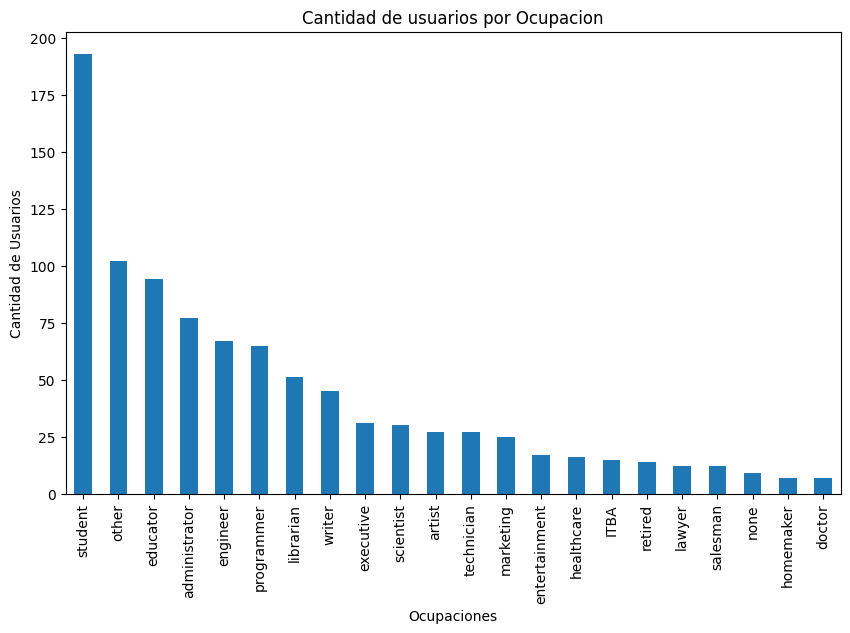

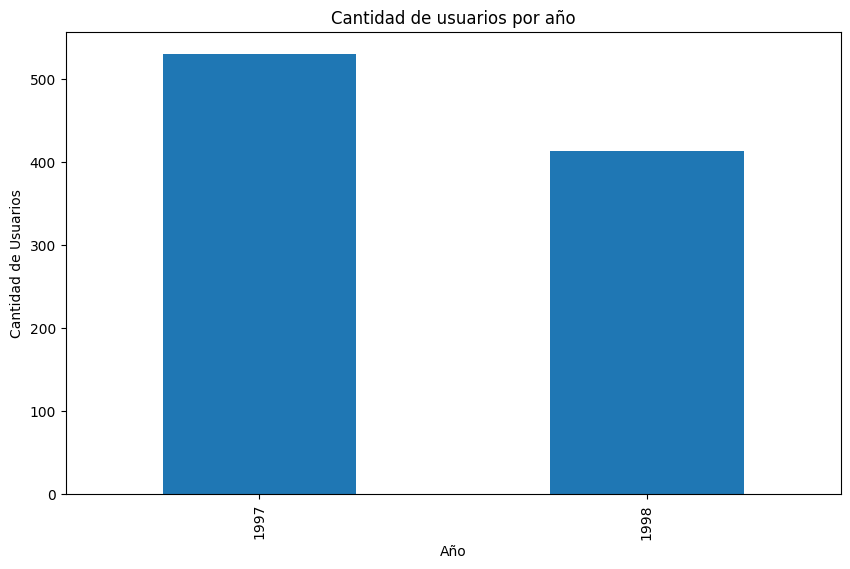

In [123]:
Usuario.get_stats(users_db)

# CLASE PERSONAS

In [65]:
import helper

class Persona: #id,Full Name,year of birth,Gender,Zip Code
    def __init__(self, full_name, year_birth, gender, zip_code,id = None):
        self.name = full_name
        self.birth_year = year_birth
        self.gender = gender
        self.zip_code = zip_code
        self.id = id

    def __repr__(self):
        # Este método debe imprimir la información de esta película.
        output = f"ID: {self.id}\nNombre completo: {self.name}\nAnio nacimiento: {self.birth_year}\nGenero:{self.gender}\nCod.Postal:{self.zip_code}"
        return output    

    def write_df(self, df_ppl):
        # Este método recibe el dataframe de usuarios y agrega al usuario
        # Si el id es None, toma el id más alto del DF y le suma uno. Si el 
        # id ya existe, no la agrega y devuelve un error.
        if self.id in df_ppl["id"].values: return -1        
        if self.id is None: self.id = df_ppl["id"].max() + 1 if not df_ppl.empty else 1  
        new_row = [self.id,self.name,self.birth_year,self.gender,self.zip_code]  
        df_ppl.loc[len(df_ppl)] = new_row   
        return df_ppl
    
    @classmethod
    def create_df_from_csv(cls, filename):
        # Este class method recibe el nombre de un archivo csv, valida su estructura 
        # y devuelve un DataFrame con la información cargada del archivo 'filename'.        
        try:
            df = pd.read_csv(filename)
            if (df.columns.tolist() !=  helper.get_pple_structure()):                
                raise ValueError("El archivo CSV no contiene todas las columnas requeridas.")
            return df        
        except Exception as e:
            print(f"Error al procesar el archivo CSV '{filename}': {str(e)}")
            return None

    @classmethod
    def df_filter(cls,df_ppl,name=None, years=None, gender=None, zip_code=None,id = None):
        mask = df_ppl.copy()
        if id is not None:
            mask = mask[mask['id'] == id]
        if gender is not None:
            mask = mask[mask['Gender'] == gender]
        if zip_code is not None:
            mask = mask[mask['Zip Code'].apply(lambda x:int(x))== zip_code]
        if years is not None:
            mask = mask[(mask['year of birth'].apply(lambda x: int(x))>= years[0]) & (mask['year of birth'].apply(lambda x: int(x))<= years[1])]
        if name is not None:
           mask = mask[mask['Full Name'].str.contains(name)]
        
        return mask

    @classmethod
    def get_from_df(cls, df_ppl, nombre=None, years=None, gender=None, zip_code=None,id = None):
        # Este class method devuelve una lista de objetos 'Persona' buscando por: id, anios, genero, cod.postal        
        mask = Persona.df_filter(df_ppl,name=nombre,years=years,gender=gender,zip_code=zip_code,id=id)        
        personas = []
        for index, row in mask.iterrows():
            persona = cls(full_name = row["Full Name"],
                          id = row["id"],
                          year_birth=row["year of birth"],
                          zip_code=row["Zip Code"],
                          gender=row["Gender"])
            personas.append(persona)        
        return personas



personita = Persona(full_name="Juan Pelotudo",year_birth="1997",gender="M",zip_code=66480,id=123)
personita

ID: 123
Nombre completo: Juan Pelotudo
Anio nacimiento: 1997
Genero:M
Cod.Postal:66480

In [66]:
personitas = Persona.create_df_from_csv("../Data/personas.csv").head(3)
personita.write_df(personitas)
personitas

,id,Full Name,year of birth,Gender,Zip Code
0,1,Robert Stanley,1974,M,85711
1,2,Heather Bossey,1945,F,94043
2,3,Don Davis,1975,M,32067
3,123,Juan Pelotudo,1997,M,66480


In [67]:
Persona.get_from_df(df_ppl=personitas,years=[1970,1990],zip_code=32067)

[ID: 3
 Nombre completo: Don Davis
 Anio nacimiento: 1975
 Genero:M
 Cod.Postal:32067]

In [69]:
personitas = Persona.create_df_from_csv("../Data/personas.csv").head(3)
personitas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             3 non-null      int64 
 1   Full Name      3 non-null      object
 2   year of birth  3 non-null      int64 
 3   Gender         3 non-null      object
 4   Zip Code       3 non-null      object
dtypes: int64(2), object(3)
memory usage: 252.0+ bytes


In [72]:
personitas["Zip Code"].iloc[1]

'94043'

In [73]:
personitas =pd.read_csv("../Data/personas.csv").head(3)
personitas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   id             3 non-null      int64 
 1   Full Name      3 non-null      object
 2   year of birth  3 non-null      int64 
 3   Gender         3 non-null      object
 4   Zip Code       3 non-null      object
dtypes: int64(2), object(3)
memory usage: 252.0+ bytes
